# Music Taste Analysis

Ever been asked what sort of music you like and felt unable to describe it convincingly? This notebook represents my effort to once and for all answer the question, because, yes, I regard it to be this complicated.

### How to Use

My first pass at this depended upon [Watsonbox's Exportify](https://github.com/watsonbox/exportify), but I decided I didn't like his version because of bugs and inadequate output detail. So I [went and forked it](https://github.com/pavelkomarov/exportify), cleaned up [the](https://github.com/pavelkomarov/exportify/blob/master/app.html) [code](https://github.com/pavelkomarov/exportify/blob/master/exportify.js), and [hosted it](https://pavelkomarov.com/exportify/app) myself.

As such, the code here depends on `.csv` inputs in the format output by [my version](https://pavelkomarov.com/exportify/app).
1. To get started, hop on over there, sign in to Spotify to give the app access to your playlists, and export whatever you like.
2. Next, either download this `.ipynb` file and run the notebook yourself or [launch it in Binder](https://mybinder.org/v2/gh/pavelkomarov/exportify/master).
3. Either put the downloaded `.csv` in the same directory as the notebook, or upload it in Binder.
4. Open the `.ipynb` through your browser, update the `filename` variable in the first code cell to point to your playlist instead, and `shift+enter` in each following code cell to generate the corresponding plot. (Or select `Cell` -> `Run All` from the menu to make all graphs at once.)

### Read the Data

For years I've been accumulating my favorite songs in a single master playlist called [`music that tickles my fancy`](https://open.spotify.com/playlist/3wZ26eXVkSaPmfKA4tc1pT). It's thousands of songs. This is what I'll be analyzing. Let's take a look at the first few rows to get a sense of what we're dealing with.

In [1]:
filename = 'music_that_tickles_my_fancy.csv'

from matplotlib import pyplot
import seaborn
import pandas
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

# read the data
data = pandas.read_csv(filename)
print("total songs:", data.shape[0])
print(data[:3])

total songs: 2708
               Spotify ID                                     Artist IDs  \
0  3T9HSgS5jBFdXIBPav51gj  0nJvyjVTb8sAULPYyA1bqU,5yxyJsFanEAuwSM5kOuZKc   
1  2bdZDXDoFLzazaomjzoER8                         1P6U1dCeHxPui5pIrGmndZ   
2  1fE3ddAlmjJ99IIfLgZjTy                         0id62QV2SZZfvBn9xpmuCl   

                   Track Name  \
0  Fanfare for the Common Man   
1            Highschool Lover   
2             I Need a Dollar   

                                          Album Name  \
0  Copland Conducts Copland - Expanded Edition (F...   
1                                    Virgin Suicides   
2                                    I Need A Dollar   

                            Artist Name(s) Release Date  Duration (ms)  \
0  Aaron Copland,London Symphony Orchestra         1963         196466   
1                                      Air         2000         162093   
2                               Aloe Blacc   2010-03-16         244373   

   Popularity         

### Artist Bar Chart

Number of songs binned by artist. 

number of unique artists: 1136


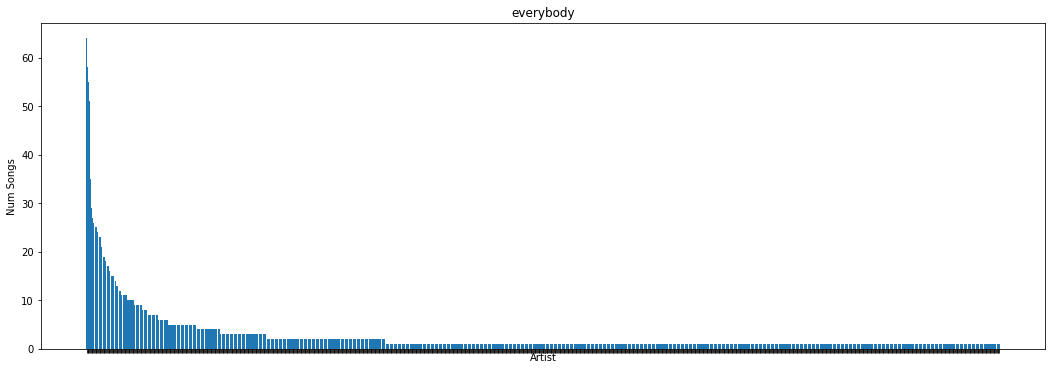

In [2]:
# count songs per artist
artists = defaultdict(int)
for i,song in data.iterrows():
	for musician in song['Artist Name(s)'].split(','):
		artists[musician] += 1

# sort for chart
artists = pandas.DataFrame(artists.items(), columns=['Artist', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique artists:", artists.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody')
pyplot.show()

Note I've attributed songs with multiple artists to multiple bars, so the integral here is the number of unique song-artist pairs, not just the number of songs.

It seems to follow a Pareto distribution. Let's try to fit one.

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


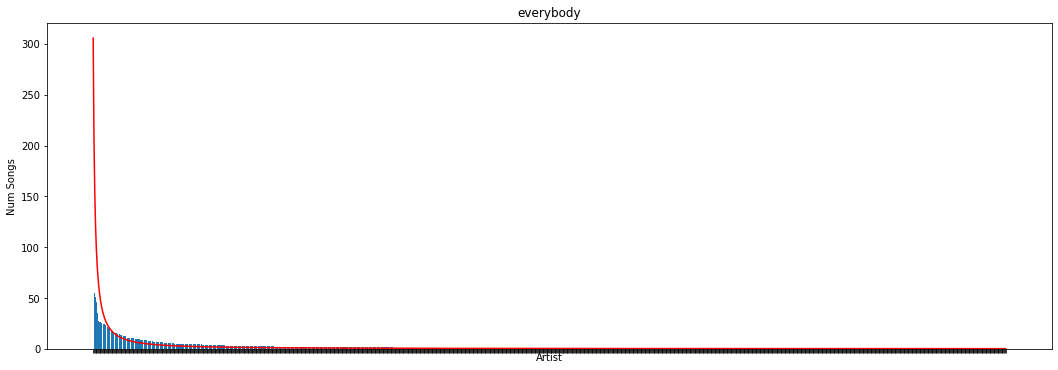

In [3]:
# Let's find the best parameters. Need x, y data 'sampled' from the distribution for
# parameter fit.
y = []
for i in range(artists.shape[0]):
	for j in range(artists['Num Songs'][i]):
		y.append(i) # just let y have index[artist] repeated for each song 

# sanity check. If the dataframe isn't sorted properly, y isn't either.
#pyplot.figure()
#pyplot.hist(y, bins=30)
        
# The documentation is pretty bad, but this is okay:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-
# ones-with-scipy-python
param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(artists.shape[0]), *param)
# param = gamma.fit(y) # gamma fits abysmally; see for yourself by uncommenting
# gamma_fitted = len(y)*gamma.pdf(range(artists.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
#pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('everybody');

Best fit is still too sharp for the data, and I tried for a good long while to get it to fit better, so I conclude this doesn't *quite* fit a power law.

Let's plot the top 50 artists so we can actually read who they are.

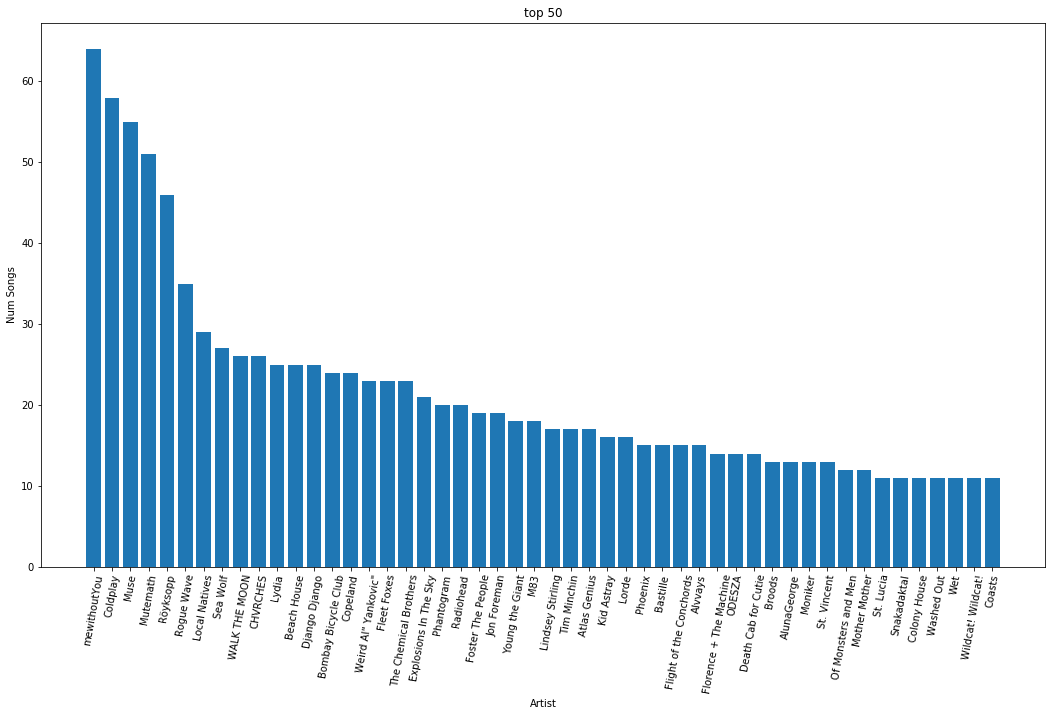

In [4]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(artists['Artist'][:50], artists['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title('top 50');

### Volume Added Over Time

My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

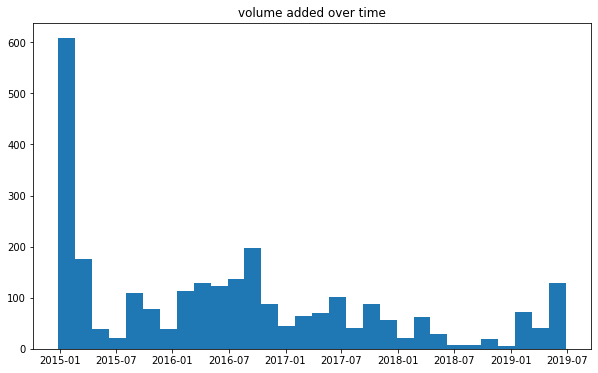

In [5]:
import pandas.plotting._converter as pandacnv
pandacnv.register() # to suppress warning

# Plot of added volume over time
parse_date = lambda d:(int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(figsize=(10, 6))
pyplot.hist([date(*parse_date(d)) for d in data['Added At']], bins=30)
pyplot.title('volume added over time');

The initial spike is from when I first stared using Spotify as the home for this collection and manually added hundreds from my previous list.

### Eclecticness Measure (Frequency Transform)

This one is a personal favorite. I want to know how many of my songs are one-offs from that artist for me--just individual pieces I found fantastic and ended up adding after a few listens--, how many are two-offs, et cetera. I know it must be heavily skewed toward the low numbers.

number of song-artist pairs represented in the eclecticness chart: 3012


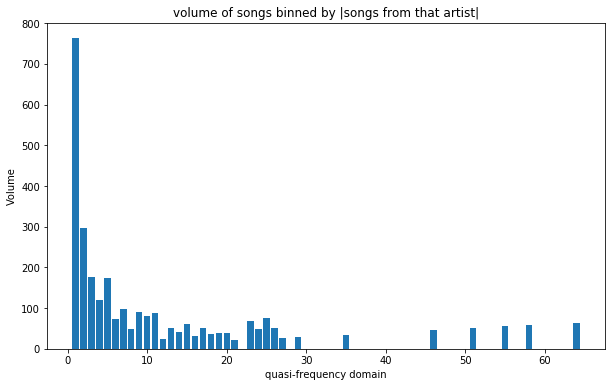

In [6]:
# bar chart of first bar chart == hipster diversity factor
frequency = defaultdict(int)
for n in artists['Num Songs']:
	frequency[n] += n
frequency = pandas.DataFrame(frequency.items(), columns=['Unique Count', 'Volume']
                           ).sort_values('Volume', ascending=False)
print("number of song-artist pairs represented in the eclecticness chart:",
      sum(frequency['Volume']))

pyplot.figure(figsize=(10, 6))
pyplot.bar(frequency['Unique Count'].values, frequency['Volume'].values)
pyplot.title('volume of songs binned by |songs from that artist|')
pyplot.xlabel('quasi-frequency domain')
pyplot.ylabel(frequency.columns[1]);

So, yes, it's much more common for an artist to make it in my list a few times than many times. In fact, the plurality of my top songs come from unique artists.

Conversely, this view also makes stark those few musicians from whom I've collected dozens.

Note that here, as in the artist bar charts, some songs are doubly-counted, because in cases artists collaborated I listed the song in both bins.

### Genres Bar Chart

Alright, enough messing around. All the above were possible with the output from Watsonbox's Exportify. Let's get to the novel stuff you came *here* for.

People describe music by genre. As we'll see, genre names are flippin' hilarious and extremely varied, but in theory if I cluster around a few, that should give you a flavor of my tastes.

number of unique genres: 683


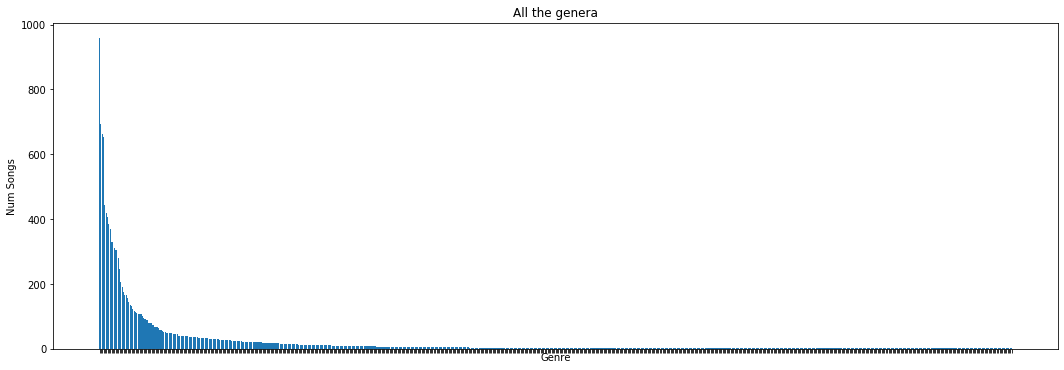

In [7]:
# count songs per genre
genres = defaultdict(int)
for i,song in data.iterrows():
    if type(song['Genres']) is str: # some times there aren't any, and this is NaN
        for genre in song['Genres'].split(','):
            if len(genre) > 0: # empty string seems to be a legit genre
                genres[genre] += 1

# sort for chart
genres = pandas.DataFrame(genres.items(), columns=['Genre', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique genres:", genres.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('All the genera');

So many! Let's do the same thing as with the artists and for giggles see if it fits a power law.

/home/pavel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


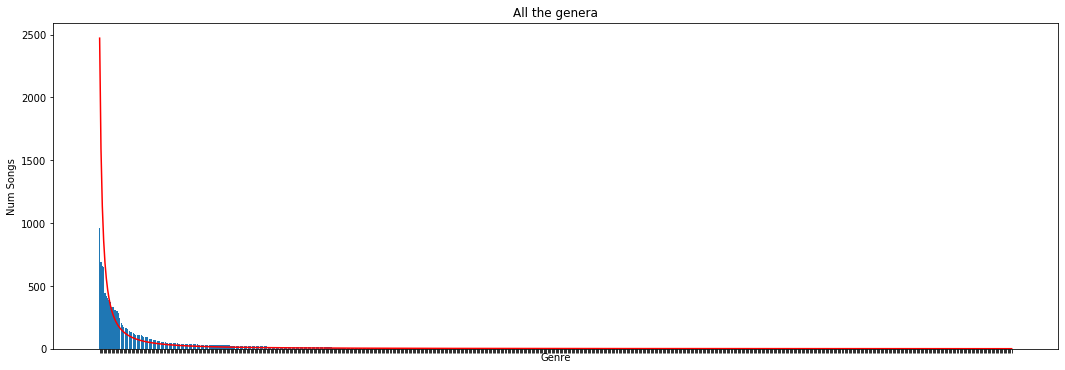

In [8]:
y = []
for i in range(genres.shape[0]):
	for j in range(genres['Num Songs'][i]):
		y.append(i) 

# sanity check
#pyplot.figure()
#pyplot.hist(y, bins=30)

param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(genres.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres['Num Songs'])
pyplot.plot(pareto_fitted, color='r')
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('All the genera');

Still too sharp, but fits better than with the artists.

Let's look at the top 50 so we can read the names.

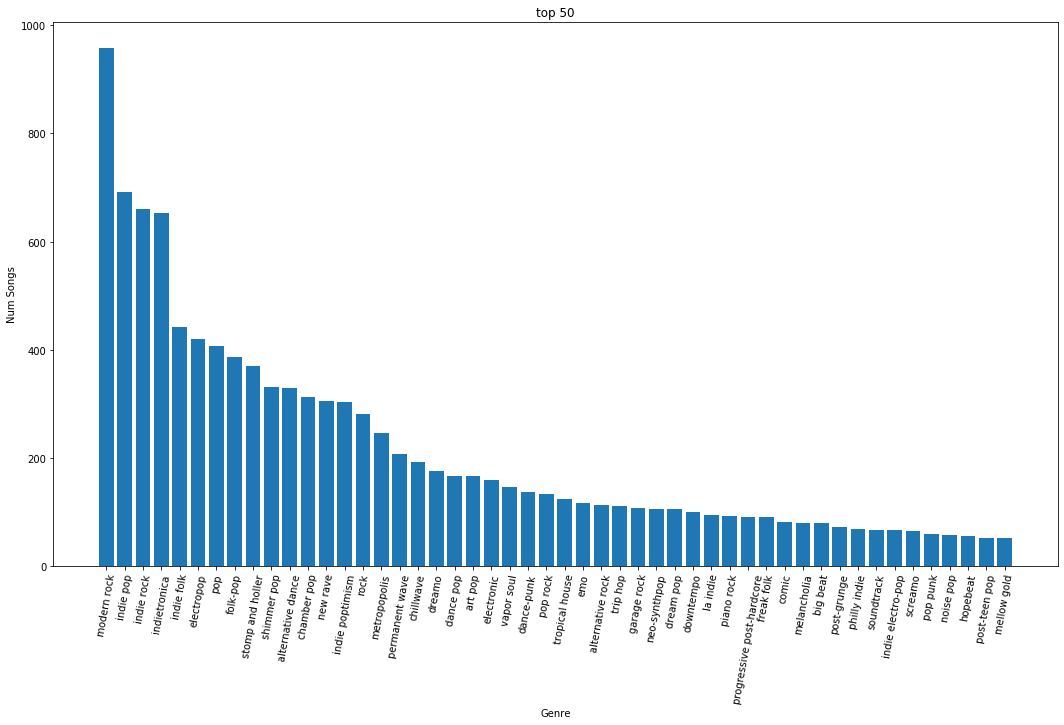

In [9]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(genres['Genre'][:50], genres['Num Songs'][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('top 50');

"Indie poptimism" lol. wtf? "Dreamo", "Vapor soul", "Freak folk", "Tropical house", "Post-grunge", "Hopebeat", "Noise pop", "Mellow gold"

These are too good. Next time someone asks me my music taste, I'm definitely using these.

If these are the *most* popular names, what are the really unique ones at the bottom of the chart?

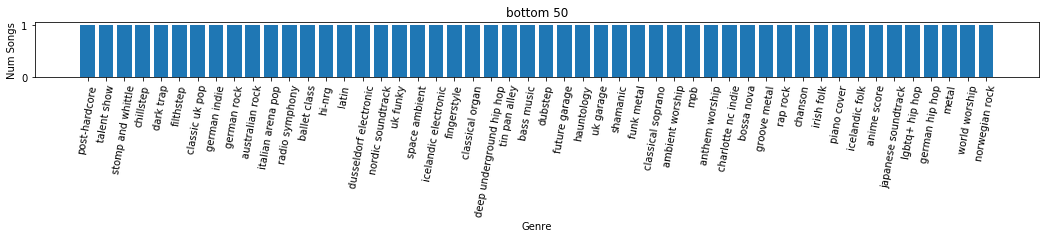

In [10]:
pyplot.figure(figsize=(18, 1))
pyplot.bar(genres['Genre'][-50:], genres['Num Songs'][-50:])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title('bottom 50');

"hauntology", "psychadelic folk", "stomp and whittle", "dark trap", "filthstep", "shamanic", "deep underground hip hop", "future garage"

That was fun.

### Release Dates

Which era of music do I prefer?

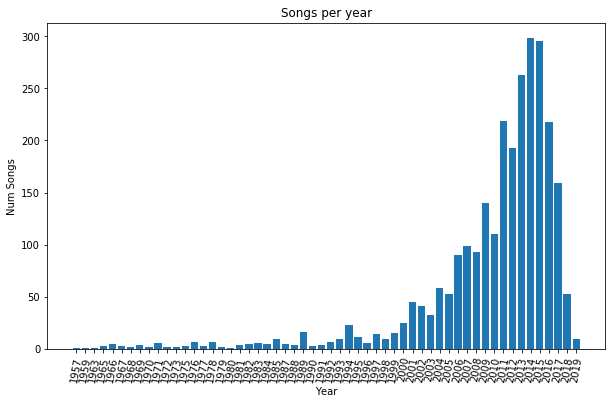

In [11]:
years = defaultdict(int)
for i,song in data.iterrows():
    years[song['Release Date'][:4]] += 1

years = pandas.DataFrame(years.items(), columns=['Year', 'Num Songs']
                          ).sort_values('Year')

pyplot.figure(figsize=(10, 6))
pyplot.bar(years['Year'], years['Num Songs'])
pyplot.xticks(rotation=80)
pyplot.xlabel(years.columns[0])
pyplot.ylabel(years.columns[1])
pyplot.title('Songs per year');

It seems to follow a Gamma distribution! This makes sense because I'm more likely to have heard things that are nearer me in time, and it takes a while for them to get through my process and become favorites.

Let's fit that gamma to the time-reversed data.

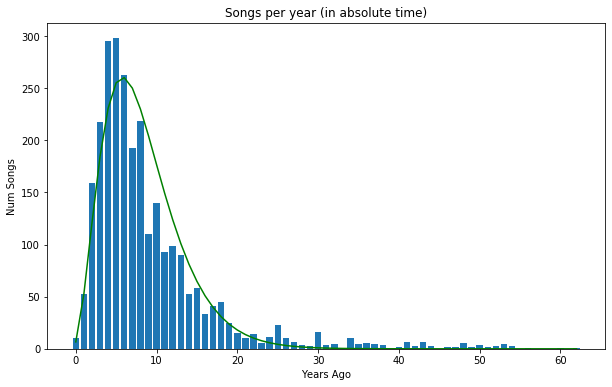

In [12]:
# Some years are missing, so transform to a dataframe that covers full time period.
eldest = int(years['Year'].values[0])
youngest = int(years['Year'].values[-1])
missing_years = [str(x) for x in range(eldest+1, youngest) if
                 str(x) not in years['Year'].values]
ago = years.append(pandas.DataFrame.from_dict(
    {'Year': missing_years, 'Num Songs': [0 for x in range(len(missing_years))]})
                  ).sort_values('Year', ascending=False).reset_index(drop=True)

y = []
for i in range(ago.shape[0]):
	for j in range(int(ago['Num Songs'][i])):
		y.append(i)

# sanity check histogram to make sure I'm constructing y properly
#pyplot.figure()
#pyplot.hist(y, bins=30)
        
param = gamma.fit(y, 10000)
gamma_fitted = len(y)*gamma.pdf(range(ago.shape[0]), *param)

pyplot.figure(figsize=(10, 6))
pyplot.bar(range(len(ago['Year'])), ago['Num Songs'])
pyplot.plot(gamma_fitted, color='g')
pyplot.xlabel('Years Ago')
pyplot.ylabel(ago.columns[1])
pyplot.title('Songs per year (in absolute time)');

Pretty good fit! I seem to be extra partial to music from about 5 years ago. We'll see whether the present or maybe the further past catches up.

### Popularity Contest

I was happy to find popularity listed as a field in Spotify's track JSON. It's a percentile between 0 and 100, rather than an absolute number of plays. Still, it can be used to give a notion of how hipster I am.

Average song popularity:  41.5
Median song popularity:  41.5
Max song popularity:  83


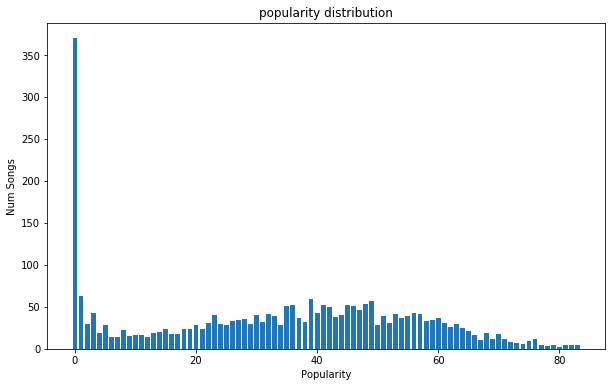

In [13]:
popularity = defaultdict(int)
for i,song in data.iterrows():
    popularity[song['Popularity']] += 1

popularity = pandas.DataFrame(popularity.items(), columns=['Popularity', 'Num Songs']
                          ).sort_values('Popularity')

pyplot.figure(figsize=(10, 6))
pyplot.bar(popularity['Popularity'].values, popularity['Num Songs'].values)
pyplot.xlabel(popularity.columns[0])
pyplot.ylabel(popularity.columns[1])
pyplot.title('popularity distribution');

print("Average song popularity: ", popularity['Popularity'].mean())
print("Median song popularity: ", popularity['Popularity'].median())
print("Max song popularity: ", popularity['Popularity'].max())

Damn, I'm a hipster.

### Track Duration

Do I prefer long songs or short ones?

Average song length: 4:05.676198670605601
Median song length: 3:55.31299999999999


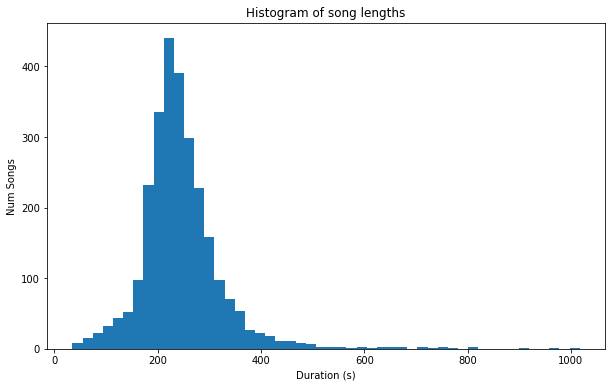

In [14]:
pyplot.figure(figsize=(10,6))
pyplot.hist(data['Duration (ms)']/1000, bins=50);
pyplot.xlabel('Duration (s)')
pyplot.ylabel('Num Songs')
pyplot.title('Histogram of song lengths')

mean = data['Duration (ms)'].mean()/1000
median = data['Duration (ms)'].median()/1000
print("Average song length: " + str(int(mean//60)) + (":" if mean%60 >=10 else ":0")
      + str(mean%60))
print("Median song length: " + str(int(median//60)) + (":" if median%60 >=10 else ":0")
      + str(median%60))

Median is lower than the mean, so I'm skewed right. That is, I like a few really long songs. What are they?

In [15]:
print("Longest Hall of Fame:")
print(data[['Track Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)']].sort_values(
    'Duration (ms)', ascending=False)[:10])

Longest Hall of Fame:
                                             Track Name  \
709                                               Irene   
1961  The Return of the King (From The Lord of the R...   
465                                   The Cure For Pain   
2425              Shine On You Crazy Diamond (Pts. 1-5)   
143   Two Step - Live At Piedmont Park, Atlanta, GA ...   
1479                                          Cage-Nerd   
2426              Shine On You Crazy Diamond (Pts. 6-9)   
145   Warehouse - Live At Piedmont Park, Atlanta, GA...   
144   Don't Drink the Water - Live At Piedmont Park,...   
187   With Tired Eyes, Tired Minds, Tired Souls, We ...   

                                 Artist Name(s) Release Date  Duration (ms)  
709                                 Beach House   2012-05-15        1017013  
1961  The City of Prague Philharmonic Orchestra   2004-01-01         976893  
465                                mewithoutYou   2002-01-01         908840  
2425            

### Musical Features

In the interest of understanding user tastes and providing the best possible music recommendations, Spotify has done [some really sophisticated analysis](http://benanne.github.io/2014/08/05/spotify-cnns.html) of actual track content. Music is a time series, but most similarity metrics (and most ML methods generally) require inputs to be vectors, that is: points in some feature-space. So they've transformed the tracks to numerical metrics like Energy and Valence (continuous) and Key (discrete).

For the continuous metrics, they [provide distributions across all music](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). Here they are next to similar plots of my own songs.

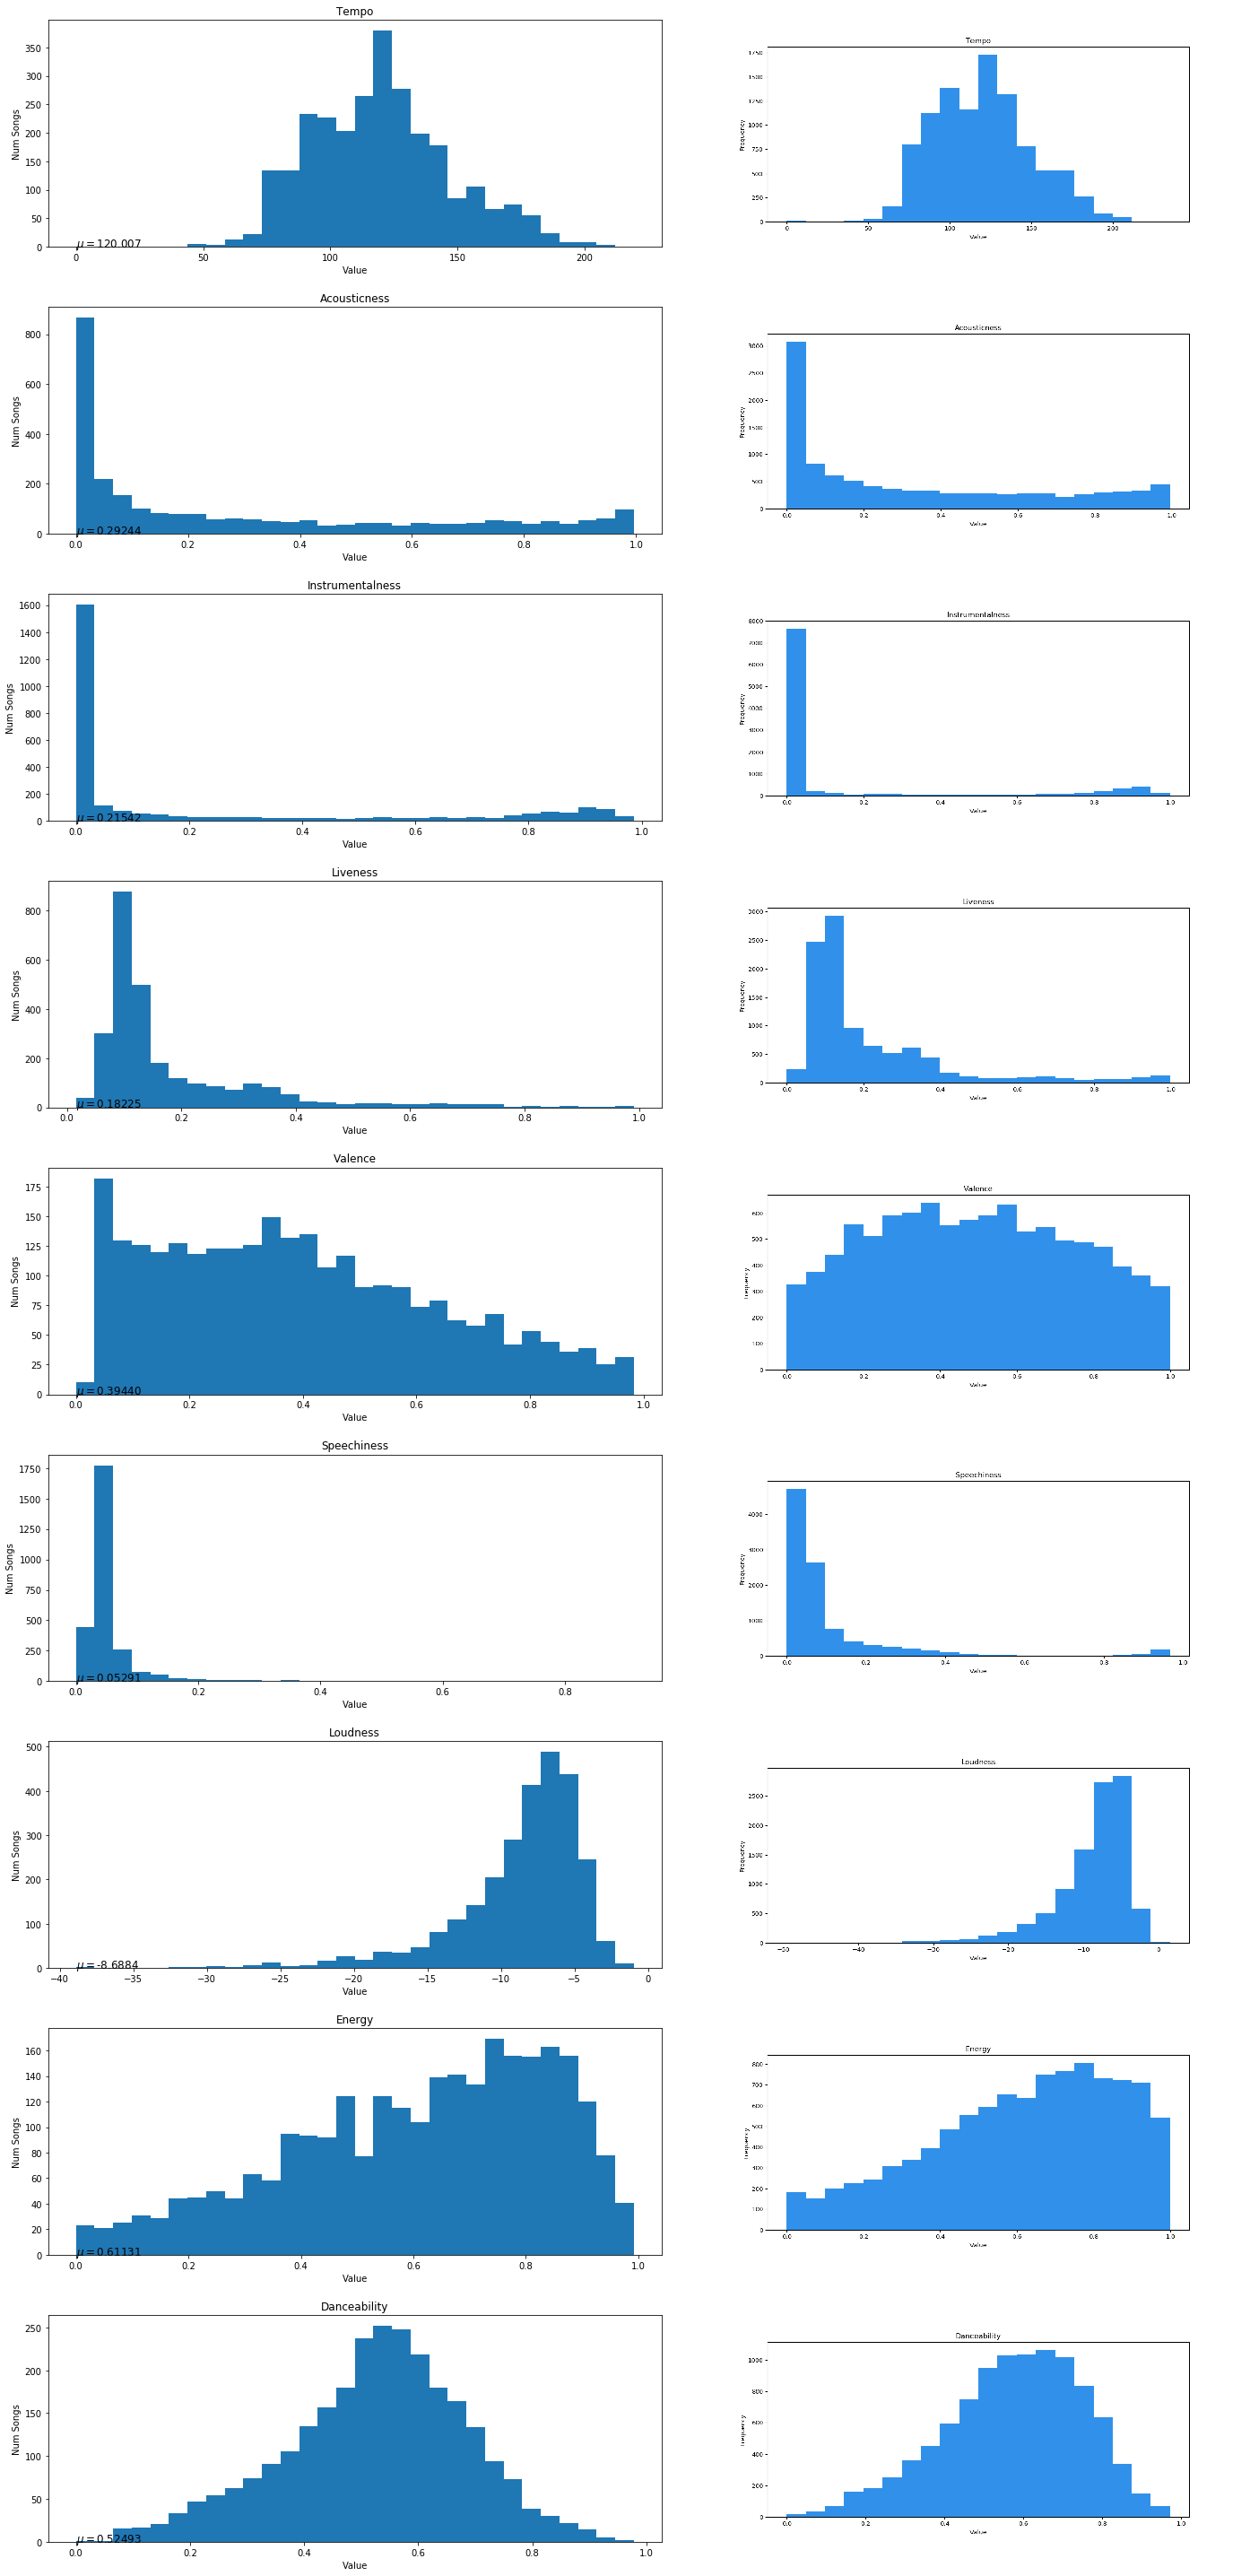

In [16]:
pyplot.figure(figsize=(20,40))

for i,category in enumerate(['Tempo', 'Acousticness', 'Instrumentalness', 'Liveness',
                            'Valence', 'Speechiness', 'Loudness', 'Energy', 'Danceability']):
    pyplot.subplot(9, 2, i*2+1)
    # It would be nice to show the KDE on these plots, but there isn't a way
    # to show it on unnormalized https://github.com/mwaskom/seaborn/issues/479
    pyplot.hist(data[category], bins=30)
    pyplot.text(min(data[category]), 0, r'$\mu=$'+str(data[category].mean())[:7], fontsize=12)
    pyplot.xlabel('Value')
    pyplot.ylabel('Num Songs')
    pyplot.title(category)

    pyplot.subplot(9, 2, i*2+2)
    pyplot.imshow(pyplot.imread('https://developer.spotify.com/assets/audio/'+
                                category.lower()+'.png'))
    pyplot.axis('off')  

pyplot.tight_layout(h_pad=2)

Looks like my preferred Tempo, Acousticness, Instrumentalness, Liveness, Speechiness, and Loudness are not much different from average. Energy is pretty similar, but I have perhaps slightly lower affinity for the super-energetic stuff. My Valence is somewhat negatively skewed, meaning I like sadder songs than average. And my Danceability peaks lower than average.

Now let's look at the discrete music features.

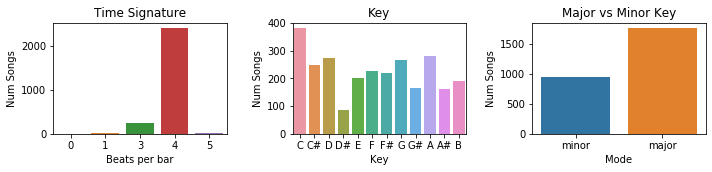

In [17]:
pyplot.figure(figsize=(10,8))

pyplot.subplot(4, 3, 10)
seaborn.countplot(data['Time Signature'])
pyplot.xlabel('Beats per bar')
pyplot.ylabel('Num Songs')
pyplot.title('Time Signature')

pyplot.subplot(4, 3, 11)
axes = seaborn.countplot(data['Key'])
axes.set(xticklabels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
pyplot.ylabel('Num Songs')
pyplot.title('Key')

pyplot.subplot(4, 3, 12)
axes = seaborn.countplot(data['Mode'])
axes.set(xticklabels=['minor', 'major'])
pyplot.ylabel('Num Songs')
pyplot.title('Major vs Minor Key');

pyplot.tight_layout(w_pad=2)

Musicians seem to favor C major and eschew D#. More than a third of my songs are in a minor key. I don't have a baseline to compare against here, but this might contribute to my lower Valence.

Looks like the vast majority of my music is 4/4 time with a good few in 3/4. I wasn't even aware there were any with 5 beats. What are those?

In [18]:
print(data.loc[data['Time Signature']==5][
    ['Track Name', 'Artist Name(s)', 'Release Date', 'Time Signature']][:20])

                          Track Name                    Artist Name(s)  \
76    Yachts - A Man Called Adam mix               Coco Steel Lovebomb   
121          Good Morning Fire Eater                          Copeland   
228                         Carry On                              fun.   
278                           Lately                       Memoryhouse   
391                         Evenstar  Howard Shore,Isabel Bayrakdarian   
452                      Make A Fist                        Phantogram   
464                              (B)                      mewithoutYou   
577                          Animals                              Muse   
745                 All That Remains                        Rogue Wave   
753                 Crush The Camera                        Rogue Wave   
831                                O                          Coldplay   
1061                           Still                The Japanese House   
1086                     Cold Sparks  

Yachts totally is 5/4 (or 10/8?), and so is Make A Fist, and so is Animals. Funny how I didn't notice the strange energetic time signature until now. But Carry On is definitely 4/4, and Pray is 6/8. So Spotify's algorithm isn't perfect at this, which is expected.

What are 0 and 1?

In [19]:
print(data.loc[data['Time Signature']==0][
    ['Track Name', 'Artist Name(s)', 'Release Date', 'Time Signature']][:10])
print(data.loc[data['Time Signature']==1][
    ['Track Name', 'Artist Name(s)', 'Release Date', 'Time Signature']][:20])

        Track Name Artist Name(s) Release Date  Time Signature
1398  Small Memory    Jon Hopkins   2009-05-05               0
                                             Track Name  \
71                                        Clair De Lune   
120                                     Top Of The Hill   
232                     I Am the Very Model of a Modern   
244                         The Last of Us (You and Me)   
249                                             Elysium   
367                                              Bowery   
511                                    The Eternal City   
574                                             Prelude   
612                                       Þú ert jörðin   
615                                               Raein   
1307                                 Campfire Song Song   
1361                                        Mylo Xyloto   
1404                                            Anagram   
1964  The Fellowship (From The Lord of the Rings

Looks like there is only one song with 0 time signature. It's a piano piece with a tempo that rises and falls. This category might be for variable tempo.

Claire De Lune is 9/8 time, so sort of waltzish but not really.

The Major General's Song is 4/4, but there are some stops in there and a lot of speaking, so I understand how that might be difficult to pick out.

Top of the Hill is maybe 8/4.

Þú ert jörðin is actually properly 1/4 time according to the internet, and relistening I understand how that could be the case. It's like there are little riffs each bar following a quadruplet pattern, but the major beats really only come every bar.

The Last of Us (You and Me) seems similar. It might be properly 1/4 time.

So it looks like this category is for actual single beats and unusual time signatures that Spotify isn't sure what to do with.

### Joint Analysis

I mostly just want to showcase what's possible. Let's plot Energy and Popularity together to see whether there is a relationship.

/home/pavel/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


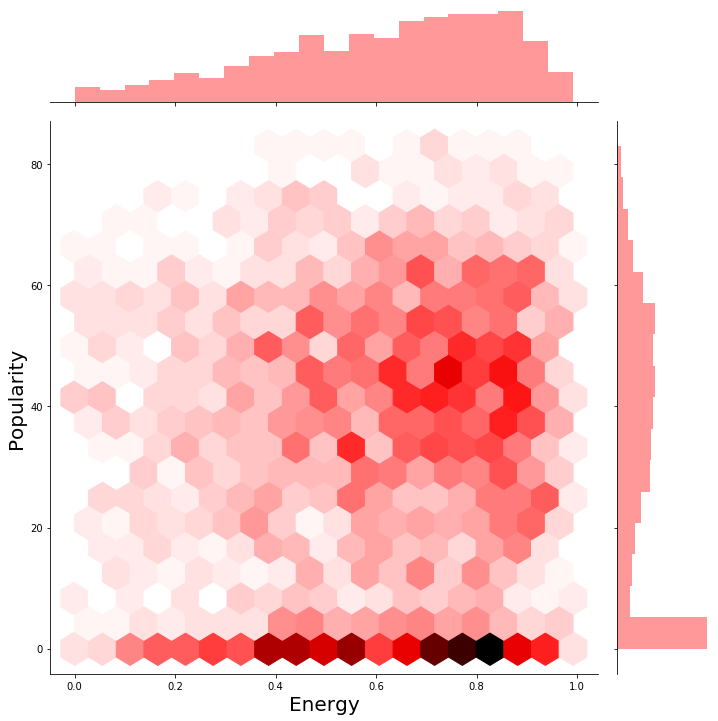

In [20]:
x = 'Energy'
y = 'Popularity'

axes = seaborn.jointplot(x=data[x], y=data[y], kind='hex', color='r', size=10)
axes.set_axis_labels(x, y, fontsize=20);

The data is pretty scattered around the whole plot, meaning the relationship here is actually pretty weak. Surprising.

### t-Distributed Stochastic Neighbor Embedding

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a method for visualizing high-dimensional data in low-dimension. Songs which are more alike will be nearer each other in the feature space, but we can't visualize a space with that many dimensions. What we can do is reconstitute the points in 2D, attempting to preserve the pairwise distances, the notions of similarity, between songs.

Index(['Release Date', 'Duration (ms)', 'Popularity', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature'],
      dtype='object')


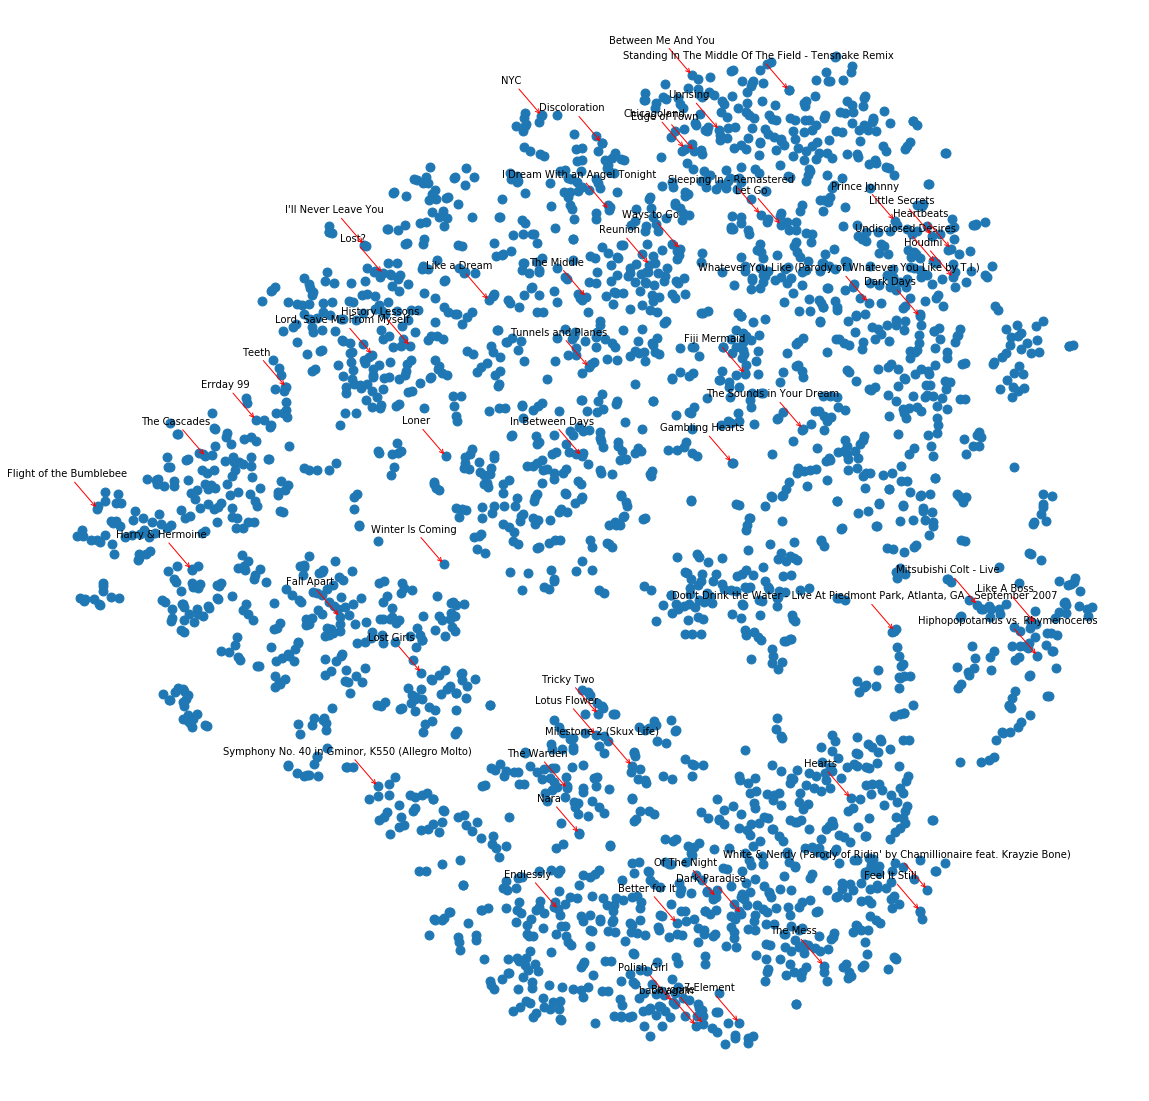

In [26]:
show_percent = 2

from sklearn.manifold import TSNE
from random import random

# Create a dataframe of only the numerical features, all normalized so embedding
# doesn't get confused by scale differences
numerical_data = data.drop(['Spotify ID', 'Artist IDs', 'Track Name', 
        'Album Name', 'Artist Name(s)', 'Added By', 'Added At',
        'Genres'], axis=1)
numerical_data['Release Date'] = pandas.to_numeric(
    numerical_data['Release Date'].str.slice(0,4))
numerical_data = (numerical_data - numerical_data.mean())/numerical_data.std()
print(numerical_data.columns)

# If you like, only include a subset of these, because the results with all
# is really hard to interpret
#tsne_data = numerical_data[['Popularity', 'Energy', 'Acousticness',
#                                'Valence', 'Loudness']]
#print("\nConsidering similarity with respect to the following features:")
#print(tsne_data.dtypes)

tsne_embedded = TSNE(n_components=2).fit_transform(numerical_data)

pyplot.figure(figsize=(20, 20))
ax = pyplot.axes(frameon=False) # Get rid of frame and ticks, because
pyplot.setp(ax, xticks=(), yticks=()) # the axes mean nothing specific.
pyplot.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], s=80)

for i,song in data.iterrows():
    if random() < show_percent*0.01: # randomly label 3% of points
    #if song['Artist Name(s)'] in ['Coldplay']:
        x, y = tsne_embedded[i]
        pyplot.annotate(song['Track Name'], (x,y), size=10,
            xytext=(-30,30), textcoords='offset points',
            ha='center',va='bottom',
            arrowprops={'arrowstyle':'->', 'color':'red'})

The above looks really different every time it gets run. The clusters don't necessarily have sensible interpretations, though you might be able to label a few of them. You can also try it with a subset of these dimensions to try to make the result more interpretable.

### The Final Frontier

Finally, I'm going to follow [this guy's example](https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3) and feed the dimension-reduced data to a one-class SVM to get a sense of what the frontier of my normal taste looks like in that space, [heat-map-of-the-universe-style](https://www.nasa.gov/mission_pages/planck/multimedia/pia16873.html).

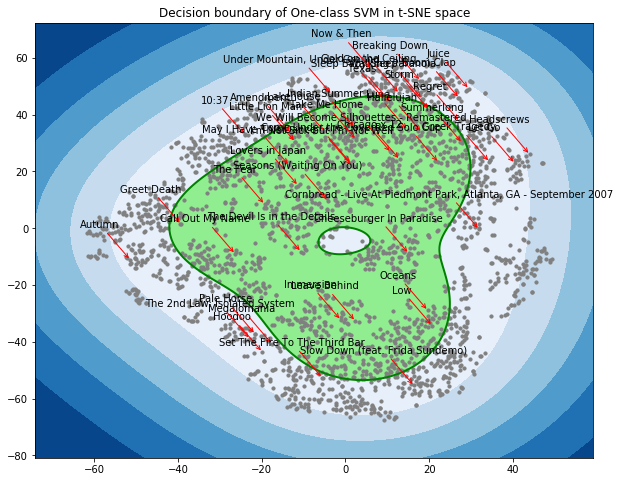

In [27]:
from sklearn.svm import OneClassSVM
import numpy

# Takes a 2D data embedding and an svm trained on it and plots the decision boundary
def plotFrontier(embedded, svm, technique_name, scale):
    # get all the points in the space, and query the svm on them
    xx, yy = numpy.meshgrid(numpy.linspace(min(embedded[:,0])*scale,
                                           max(embedded[:,0])*scale, 500),
                            numpy.linspace(min(embedded[:,1])*scale,
                                           max(embedded[:,1])*scale, 500))
    Z = svm.decision_function(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # positive Z means yes. negative means outliers.

    pyplot.figure(figsize=(10,8))
    pyplot.title('Decision boundary of One-class SVM in '+technique_name+' space')
    pyplot.contourf(xx, yy, Z, levels=numpy.linspace(Z.min(), 0, 7), cmap=pyplot.cm.Blues_r)
    pyplot.contour(xx, yy, Z, levels=[0], linewidths=2, colors='green') # the +/- boundary
    pyplot.contourf(xx, yy, Z, levels=[0, Z.max()], colors='lightgreen')

    pyplot.scatter(embedded[:, 0], embedded[:, 1], s=10, c='grey')
    for i,song in data.iterrows():
        if random() < show_percent*0.01: # randomly label 3% of points
        #if song['Artist Name(s)'] in ['Coldplay']:
            x, y = embedded[i]
            pyplot.annotate(song['Track Name'], (x,y), size=10,
                xytext=(-30,30), textcoords='offset points',
                ha='center',va='bottom',
                arrowprops={'arrowstyle':'->', 'color':'red'})
            
svm_tsne = OneClassSVM(gamma='scale')
svm_tsne.fit(tsne_embedded)
plotFrontier(tsne_embedded, svm_tsne, 't-SNE', 1.2)

Modifying the parameters of the SVM changes this picture significantly, so I'm not sure this is the best model. Gamma too large just clearly overfits the data. Gamma too small just makes the decision boundary a boring ellipse. Using `gamma='scale'` as [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) recommend is a more interesting middle ground, but still the SVM seems to believe that a great many of the songs I love fall outside the boundary.

I'll try a different dimensionality reduction technique. The original author uses Principle Component Analysis to feed the SVM.

Variance explained by PCA dimensions: [0.22508716 0.09047223]


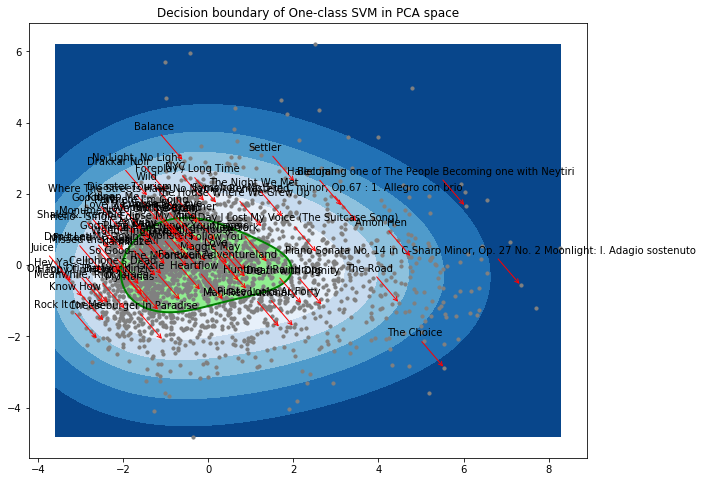

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embedded = pca.fit_transform(numerical_data)
print("Variance explained by PCA dimensions:",
      pca.explained_variance_ratio_)

svm_pca = OneClassSVM(gamma='scale')
svm_pca.fit(pca_embedded)

plotFrontier(pca_embedded, svm_pca, 'PCA', 1)

Ideally, songs falling nearer the center here, like Cheeseburger in Paradise and RAC's We Belong, are those that most characterize my taste numerically, and the odd ones, like Pink Floyd's Comfortably Numb and The Fellowship of the Ring orchestral suite, fall on the outside.

So in the end my music taste is a blob that doesn't even fit the data very well. And that's the point: Like many things, it's too complicated to boil down. You can't answer the question fully. But understanding elements of the answer can aid the process of discovery, and that's valuable. It's why Spotify is such a force. It's why Data Science.

Best of luck in your search.